# Overview

My notes and introduction to [learning Pytorch](https://pytorch.org/tutorials/beginner/deep_learning_60min_blitz.html), developing a basic convolutional neural net using pytorch methods.
First step is to import pytorch, to learn about the tensor class, the grad attribute, and the backward() function.

In [1]:
import torch

# Understanding tensors
Tensors are basically just $n$-dimensional arrays, with the extra ability to track the changes that are applied to them, and calculate a derivative based on those changes. They do not have to be the same size in each dimension.

I set up a simple easy to understand tensor, and set requires_grad to True to more easily understand the effects of backward() and grad.

backward can only be applied to non scalar values (still tensors?) if you provide an argument of the same dimensions as the desired output.

backward needs to be called before using the grad value, since backward calculates the gradient.

In this case, all the values in x.grad sum to 1, which make. This is because calculating the mean requires summing all the values (which are removed when differentiating) and then dividing by the number of values. So for N values i, each value i goes to i/N.

If all the values were equal to two, I would expect the sum of the gradient structure to equal 2.

If `backward` is run multiple times, there is some kind of compounding effect, until x is redefined and gradients are recalculated. This bears investigating. However, in most uses I don't expect this to be an issue

In [2]:
x = torch.ones((1,3), requires_grad=True) 
out1=x.sum()
out2=x.mean()

out1.backward(retain_graph=True)
print(x.grad)

out2.backward(retain_graph=True) 
print(x.grad)


print("\n\n")
w=x*2
out=w.sum()
out.backward() 
print(w.grad)
print(x.grad)


# running this section repeatedly, continuously changes gradient .1333 -> 0.2 -> 0.26667... unless x is reinitialized



tensor([[1., 1., 1.]])
tensor([[1.3333, 1.3333, 1.3333]])



None
tensor([[3.3333, 3.3333, 3.3333]])


In [3]:
import torch.nn as nn
import torch.nn.functional as F


# Setting up network class

In convolutional neural nets, the input image often has multiple channels (like RGB) which form the intended image only when combined. These can be visualized as three layers of single color images that are overlaid. Therefore, the (ordinarily 2d) filtering kernel needs to be applied separately to each of these channels, giving it an effective depth of the number of channels. From the initial image, one can apply many different kernels at the same time, by introducing  a fourth dimension to the kernel, resulting in many different feature maps. So, the dimensions of the kernel are as follows (unordered): 
(number of separate feature maps to generate, number of input image channels, 2d size of filter to apply on the input image)

From this it is somewhat easier to understand the network class that we are creating. There are two sequential convolution layers. The first takes an image with only one channel, modifies it with a 3x3 filter, and outputs an image with six channels. The second takes an image of 6 channels, and outputs one with 16 channels, again using a 3x3 filter.

I'm unsure why `Linear` function is needed...

To understand the purpose and function of `Linear`. Each output of the `Linear` function is a linear combination of the inputs, with a bias term. The weights (and bias) can be learned and updated. This is used after the convolution step, so the features have already been found, and now it is deciding what they mean.

In [12]:
a = nn.Linear(10,15) # stretches (or compresses) 10 values to 15
# a(10) # throws error
b = torch.ones(1,10)
print(b)
print(a(b))
print(min(a(b)), max(a(b)))

tensor([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]])
tensor([[-0.0254,  1.1549, -0.1922,  0.1321, -0.4913, -0.0083, -0.7039, -0.3466,
          0.3313,  0.5105, -0.1675,  1.2171,  0.3180, -0.0971,  0.0688]],
       grad_fn=<AddmmBackward>)
tensor([-0.0254,  1.1549, -0.1922,  0.1321, -0.4913, -0.0083, -0.7039, -0.3466,
         0.3313,  0.5105, -0.1675,  1.2171,  0.3180, -0.0971,  0.0688],
       grad_fn=<SelectBackward>) tensor([-0.0254,  1.1549, -0.1922,  0.1321, -0.4913, -0.0083, -0.7039, -0.3466,
         0.3313,  0.5105, -0.1675,  1.2171,  0.3180, -0.0971,  0.0688],
       grad_fn=<SelectBackward>)


In [13]:

# grad returns the value of the derivative of the function at the current value of x
# confused about what happens when calling backwards() multiple times


class Net(nn.Module):
    def __init__(self):

        # call to the init function of the class that Net extends
        super(Net,self).__init__()

        # what are convs used for? why 2?
        # one input image channel (?), 6 outputs, 3x3 square convolution
        self.conv1 = nn.Conv2d(1,6,3)

        # (6 input channels, 16 outputs, 3x3 square kernel?)
        self.conv2 = nn.Conv2d(6,16,3)

        # what are linears used for? clearly they go in order, why 16*6*6 inputs? why 10 outputs?
        # why 3?
        self.fc1 = nn.Linear(16*6*6, 120) #576 -> 120
        self.fc2 = nn.Linear(120,84) # first here is second from previous # 120->84
        self.fc3 = nn.Linear(84, 10) # 84 -> 10

    def forward(self,x):
        """
        what does this do?
        what does relu do?
        what does max_pool do?
        """

        # convolution step
        x = F.max_pool2d(F.relu(self.conv1(x)), (2,2))
        x = F.max_pool2d(F.relu(self.conv2(x)), 2)

        # reformat x to be useable as typical neural network
        x = x.view(-1, self.num_flat_features(x)) # has to be one dimensional for Linear function

        # regular neural network behavior, each step is linear combination
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

    def num_flat_features(self, x):
        size = x.size()[1:]
        num_features=1
        for s in size:
            num_features *= s

        return num_features

# Understanding the functions
`forward`
x is the input, which will be reshaped to a two dimensional tensor by the view function.
max_pool2d takes a kernel size, and a step size(tuple is useful for different step size by dimension), a tensor that is 1/(step size) the input, where each entry is the maximum from the original in the pool of the kernel size. It does this separately for each channel.
F.relu is an element wise transformation, setting all negative values equal to zero.
So, in combination, it takes an input, sets all negatives to zero, and then takes the regional maxima of each channel.

`view` rearraneges the data into a new shape, with `-1` meaning to infer the needed shape from what is left over in the other dimesnsions. In this case, it is being reshaped to preserve the first dimension, and combine all the others into a single dimension, so that they can be linearly combined to make a prediction.

In [15]:

# create network
net=Net()
print(net)

# get parameters of the network
params = list(net.parameters())
print(len(params))
print(params[0].size())

# random 32x32 input in a 4d tensor (what are 1s for? why 2 extra indices to tensor?)
input = torch.randn(1,1,32,32) 
out = net(input)
print(out)

# clears all gradient computations (sets to zero)
net.zero_grad()
out.backward(torch.randn(1,10))

Net(
  (conv1): Conv2d(1, 6, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=576, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)
10
torch.Size([6, 1, 3, 3])
shape of input is torch.Size([1, 1, 32, 32])
shape of input is torch.Size([1, 16, 6, 6])
shape of input is torch.Size([1, 576])
tensor([[-0.0416, -0.1104,  0.0316, -0.1033,  0.1010,  0.0539,  0.0441,  0.0650,
         -0.1595,  0.0115]], grad_fn=<AddmmBackward>)


# Training
We have a network that can make prediction, but it hasn't been able to learn yet, so it's predictions are a very complicated way of choosing randomly. The next step is to train it by giving it feedback from predictions and tests. For this we will need a measure of how wrong a guess is, called a loss function. In this case we use Mean Squared Error, but there are others, which are useful depending on how the target variable is distributed. Gaussian vs binary, with outliers, etc.

In [8]:
output = net(input)
target = torch.randn(10)  # a dummy target, for example
target = target.view(1, -1)  # make it the same shape as output
criterion = nn.MSELoss()

loss = criterion(output, target)
print(loss)

tensor(0.8857, grad_fn=<MseLossBackward>)


In [9]:
net.zero_grad() # zeroes the gradient buffers of all parameters

print('conv1.bias.grad before backward')
print(net.conv1.bias.grad)

loss.backward()

print('conv1.bias.grad after backward')
print(net.conv1.bias.grad)

conv1.bias.grad before backward
tensor([0., 0., 0., 0., 0., 0.])
conv1.bias.grad after backward
tensor([-6.7526e-05,  1.0553e-02, -1.7950e-03,  2.9557e-03,  4.6966e-03,
        -3.4039e-03])


This will update the weights using stochastic gradient descent. There are many other optimization algorithms. Many are found in the torch.optim module

- Gradient descent: take a step proportional to the negative of the gradient, in that direction (very simple)
- Stochastic gradient descent: Same as gradient descent, except gradient is approximate, so it's computationally faster
- Adaptive Momentum: adds a bit of the previous calculation to the current, giving it effective momentum
- Conjugate Gradient: ??? 
- Quasi Newton Method: Uses an approximation of newton's method
- Adadelta/Adagrad: use adaptive learning rates (different methods) on top of SGD
- ADAM: combines adaptive learning rates and adaptive momentum
- MiniBatch: calculates and combines the gradient for many target values at once before updating model
...

In [10]:
print(net.parameters)
learning_rate = 0.01
for f in net.parameters():
    f.data.sub_(f.grad.data * learning_rate)

<bound method Module.parameters of Net(
  (conv1): Conv2d(1, 6, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=576, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)>


In [ ]:
import torch.optim as optim

# create your optimizer
optimizer = optim.SGD(net.parameters(), lr=0.01)

# in your training loop:
optimizer.zero_grad()   # zero the gradient buffers
output = net(input)
loss = criterion(output, target)
loss.backward()
optimizer.step()    # Does the update

# Building a Classifier
At this point, we are going to build and train a functional classifier, which we will then evaluate. I want to be able to explain all the the decisions that are made, and alternate methods of evaluation.

In [12]:
import torch
import torchvision
import torchvision.transforms as transforms

transform is a composition of two image transformations. The first turns an array into a tensor (simple type compatibility), and the second normalizes each elements means and standard deviations to 0.5.

The rest is just fetching data.

In [17]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=4,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Compose(
    ToTensor()
    Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
)
Files already downloaded and verified
Files already downloaded and verified


A basic examination of the data. Pick a few images at random, and display them

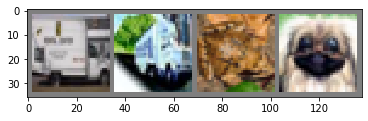

truck truck  frog   dog


In [18]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

Define the net.
We have two convolution steps, and a pooling step. 

In [ ]:
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


net = Net()

In [ ]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

In [ ]:
for epoch in range(2):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0

print('Finished Training')

In [ ]:
PATH = './cifar_net.pth'
torch.save(net.state_dict(), PATH)

In [ ]:
dataiter = iter(testloader)
images, labels = dataiter.next()

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))

In [ ]:
net = Net()
net.load_state_dict(torch.load(PATH))

In [ ]:
outputs = net(images)

In [ ]:
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join('%5s' % classes[predicted[j]]
                              for j in range(4)))

correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

In [ ]:
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1


for i in range(10):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))

# Parallel Computing


In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Assuming that we are on a CUDA machine, this should print a CUDA device:

print(device)

In [ ]:
net.to(device)

In [ ]:
inputs, labels = data[0].to(device), data[1].to(device)

In [ ]:
device = torch.device("cuda:0")
model.to(device)

In [ ]:
mytensor = my_tensor.to(device)

In [ ]:
model = nn.DataParallel(model)

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:
class RandomDataset(Dataset):

    def __init__(self, size, length):
        self.len = length
        self.data = torch.randn(length, size)

    def __getitem__(self, index):
        return self.data[index]

    def __len__(self):
        return self.len

rand_loader = DataLoader(dataset=RandomDataset(input_size, data_size),
                         batch_size=batch_size, shuffle=True)

In [ ]:
class Model(nn.Module):
    # Our model

    def __init__(self, input_size, output_size):
        super(Model, self).__init__()
        self.fc = nn.Linear(input_size, output_size)

    def forward(self, input):
        output = self.fc(input)
        print("\tIn Model: input size", input.size(),
              "output size", output.size())

        return output

In [ ]:
model = Model(input_size, output_size)
if torch.cuda.device_count() > 1:
  print("Let's use", torch.cuda.device_count(), "GPUs!")
  # dim = 0 [30, xxx] -> [10, ...], [10, ...], [10, ...] on 3 GPUs
  model = nn.DataParallel(model)

model.to(device)

In [ ]:
for data in rand_loader:
    input = data.to(device)
    output = model(input)
    print("Outside: input size", input.size(),
          "output_size", output.size())